In [1]:
import os
os.chdir("D:/Downloads")

In [2]:
print(os.getcwd())


D:\Downloads


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [4]:
df, meta = pyreadstat.read_sav("Scotland.sav")
print(df) 

      Respondent_Serial   Q1    Q2  Q2_dkref   Q3  ReQ3_MaritalStatus  Q4_1  \
0                   2.0  2.0  28.0       NaN  1.0                 0.0   0.0   
1                   7.0  1.0  23.0       NaN  1.0                 0.0   0.0   
2                   8.0  2.0  18.0       NaN  1.0                 0.0   0.0   
3                   9.0  2.0  20.0       NaN  1.0                 0.0   0.0   
4                  11.0  2.0  20.0       NaN  1.0                 0.0   0.0   
...                 ...  ...   ...       ...  ...                 ...   ...   
3503             4240.0  1.0  34.0       NaN  1.0                 0.0   0.0   
3504             4241.0  2.0  28.0       NaN  1.0                 0.0   0.0   
3505             4242.0  2.0  25.0       NaN  2.0                 1.0   0.0   
3506             4243.0  2.0  27.0       NaN  1.0                 0.0   0.0   
3507             4244.0  2.0  29.0       NaN  2.0                 1.0   0.0   

      Q4_2  Q4_3  Q4_4  ...  T3_24mth_SI  Yr3_SI_12

In [5]:
df = df.dropna(subset=['SI_new'])  

In [6]:
df['SI_new']

3       0.0
4       1.0
5       0.0
6       1.0
7       0.0
       ... 
3502    0.0
3504    0.0
3505    1.0
3506    0.0
3507    2.0
Name: SI_new, Length: 2823, dtype: float64

In [7]:
df = df[df['SI_new'].isin([0, 1])]

In [9]:
features = [
    'BDI_tot', 'BSS_total', 'Defeat_total',
    'Entrapment_total', 'Stress_total', 'Resilience_total',
    'Impuls_t', 'ACSS_tot'
]
df = df.dropna(subset=features)
X = df[features].values
y = df['SI_new'].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))


In [10]:
def add_gaussian_noise(X, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

X_noisy = add_gaussian_noise(X_scaled)

In [11]:
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in skf.split(X_scaled, y):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    X_train_noisy = X_noisy[train_idx]
    break

In [13]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1760, 1: 779}


In [14]:
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


In [15]:
#CLean Data Model
model = build_model(X_train.shape[1:])
history_clean = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                          epochs=50, batch_size=32, class_weight=class_weights, verbose=1) #change epochs between 10 and 50
initial_weights = model.get_weights()

y_score_clean = model.predict(X_val)
y_pred_clean = (y_score_clean > 0.5).astype(int)
print("Clean Data Classification Report:")
print(classification_report(y_val, y_pred_clean))
print("ROC-AUC (Clean):", roc_auc_score(y_val, y_score_clean))


Epoch 1/50
64/64 [==============================] - 4s 18ms/step - loss: 0.5309 - accuracy: 0.7853 - val_loss: 0.4835 - val_accuracy: 0.7953
Epoch 2/50
64/64 [==============================] - 1s 9ms/step - loss: 0.4746 - accuracy: 0.7942 - val_loss: 0.4527 - val_accuracy: 0.8189
Epoch 3/50
64/64 [==============================] - 1s 8ms/step - loss: 0.4695 - accuracy: 0.7942 - val_loss: 0.4317 - val_accuracy: 0.8209
Epoch 4/50
64/64 [==============================] - 1s 8ms/step - loss: 0.4637 - accuracy: 0.7967 - val_loss: 0.4286 - val_accuracy: 0.8209
Epoch 5/50
64/64 [==============================] - 0s 7ms/step - loss: 0.4614 - accuracy: 0.7947 - val_loss: 0.4317 - val_accuracy: 0.8268
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 0.4588 - accuracy: 0.7922 - val_loss: 0.4148 - val_accuracy: 0.8268
Epoch 7/50
64/64 [==============================] - 0s 7ms/step - loss: 0.4613 - accuracy: 0.7932 - val_loss: 0.4472 - val_accuracy: 0.8051
Epoch 8/50
64/64 [=

In [16]:
#Noisy Model
model.set_weights(initial_weights)
history_noisy = model.fit(X_train_noisy, y_train, validation_data=(X_val, y_val),
                          epochs=50, batch_size=32, class_weight=class_weights, verbose=1) #change epochs between 10 and 50

y_score_noisy = model.predict(X_val)
y_pred_noisy = (y_score_noisy > 0.5).astype(int)
print("Noisy Data Classification Report:")
print(classification_report(y_val, y_pred_noisy))
print("ROC-AUC (Noisy):", roc_auc_score(y_val, y_score_noisy))

Epoch 1/50
64/64 [==============================] - 1s 9ms/step - loss: 0.4296 - accuracy: 0.8109 - val_loss: 0.4640 - val_accuracy: 0.7953
Epoch 2/50
64/64 [==============================] - 0s 7ms/step - loss: 0.4301 - accuracy: 0.8163 - val_loss: 0.4527 - val_accuracy: 0.7972
Epoch 3/50
64/64 [==============================] - 0s 7ms/step - loss: 0.4287 - accuracy: 0.8159 - val_loss: 0.4700 - val_accuracy: 0.7894
Epoch 4/50
64/64 [==============================] - 0s 7ms/step - loss: 0.4275 - accuracy: 0.8129 - val_loss: 0.4272 - val_accuracy: 0.8071
Epoch 5/50
64/64 [==============================] - 0s 7ms/step - loss: 0.4246 - accuracy: 0.8178 - val_loss: 0.4281 - val_accuracy: 0.8031
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 0.4243 - accuracy: 0.8139 - val_loss: 0.4378 - val_accuracy: 0.8091
Epoch 7/50
64/64 [==============================] - 0s 8ms/step - loss: 0.4235 - accuracy: 0.8183 - val_loss: 0.4503 - val_accuracy: 0.7933
Epoch 8/50
64/64 [==

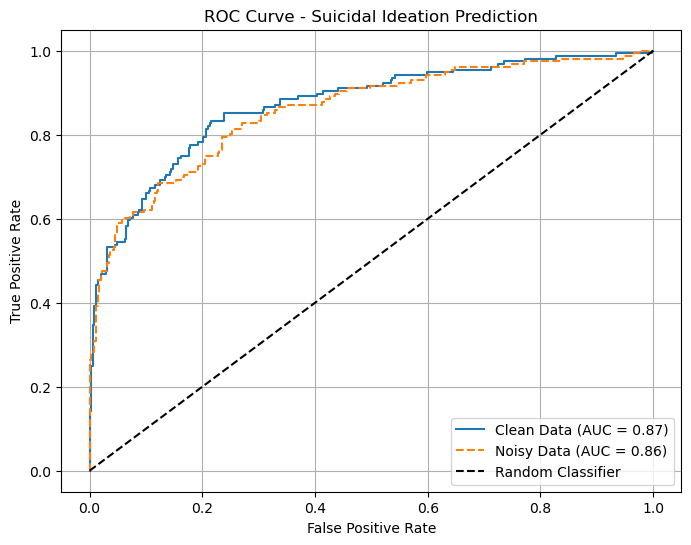

In [17]:
from sklearn.metrics import roc_curve, auc

fpr_clean, tpr_clean, _ = roc_curve(y_val, y_score_clean)
roc_auc_clean = auc(fpr_clean, tpr_clean)

fpr_noisy, tpr_noisy, _ = roc_curve(y_val, y_score_noisy)
roc_auc_noisy = auc(fpr_noisy, tpr_noisy)

plt.figure(figsize=(8, 6))
plt.plot(fpr_clean, tpr_clean, label=f'Clean Data (AUC = {roc_auc_clean:.2f})')
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy Data (AUC = {roc_auc_noisy:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Suicidal Ideation Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

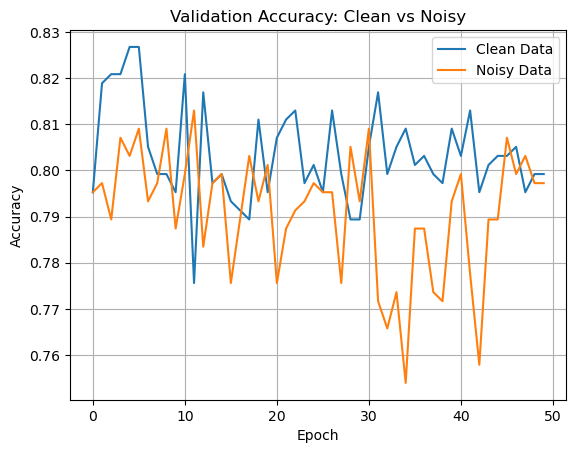

In [18]:
plt.plot(history_clean.history['val_accuracy'], label='Clean Data')
plt.plot(history_noisy.history['val_accuracy'], label='Noisy Data')
plt.title("Validation Accuracy: Clean vs Noisy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()